# Text Classification with Deep Learning
Bu projede IMDB yorumları kullanılarak metin sınıflandırma modeli geliştirilmiştir. <br>
Bu proje fikri <a href="https://thecleverprogrammer.com/2020/08/31/text-classification-with-tensorflow-in-machine-learning/" target=_blank>bu sayfadan</a> alınmıştır. Adı geçen web sayfasında verilerin elde edilmesi için tensorflow_datasets kütüphanesi kullanılmıştır. Ancak bu kütüphane ile veri çekme aşamasında sorun yaşanınca verilere <a href="https://ai.stanford.edu/~amaas/data/sentiment/" target=_blank>buradan</a> erişilmiş ve kullanılmıştır.<br><br>
Elde edilen veriler, 12500'er adet pozitif ve negatif train verisi, 12500'er adet yine pozitif ve negatif test verisi olmak üzere 5000 adet yorum içermektedir.

### Verilerin Elde Edilmesi

In [89]:
import pandas as pd
import os
import seaborn as sns

In [90]:
groups = ["train", "test"]
labels = ["pos", "neg"]
txt_path="imdb/"

In [91]:
txt_list=[]
label_list=[]
group_list=[]
for group in groups:
    for label in labels:
        klasor=txt_path+group+"/"+label
        for dosya in os.listdir(klasor):
            txt_file = os.path.join(klasor, dosya)
            with open(txt_file, "r", encoding="utf-8") as f:
                satirlar = f.readlines()
            txt_list.extend(satirlar)            
            label_list.append(label)
            group_list.append(group)

In [92]:
df=pd.DataFrame({"group":group_list, "txt":txt_list, "label":label_list})

In [93]:
df.head()

,group,txt,label
0,train,Bromwell High is a cartoon comedy. It ran at t...,pos
1,train,Homelessness (or Houselessness as George Carli...,pos
2,train,Brilliant over-acting by Lesley Ann Warren. Be...,pos
3,train,This is easily the most underrated film inn th...,pos
4,train,This is not the typical Mel Brooks film. It wa...,pos


In [94]:
df["group"].value_counts()

group
train    25000
test     25000
Name: count, dtype: int64

In [95]:
df["label"].value_counts()

label
pos    25000
neg    25000
Name: count, dtype: int64

In [ ]:
df.to_csv("imdb.csv")
df[df["group"]=="train"].to_csv("train.csv")
df[df["group"]=="test"].to_csv("test.csv")

### Veri Ön İşleme

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df=pd.read_csv("imdb.csv")

<Axes: xlabel='group', ylabel='count'>

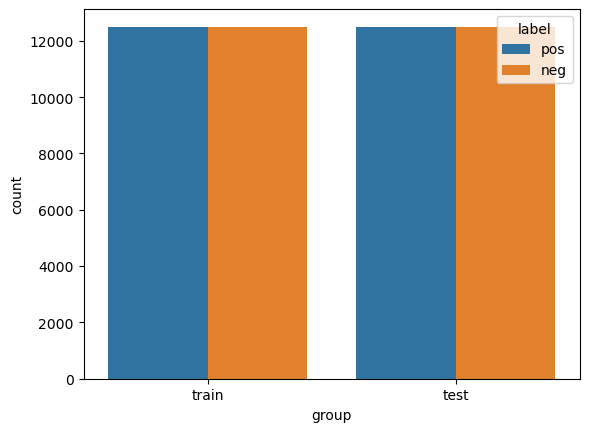

In [3]:
sns.countplot(x=df['group'], hue=df["label"])

In [4]:
d={"neg":0, "pos":1}
df["class"]=df["label"].map(d)

In [5]:
df.head()

,Unnamed: 0,group,txt,label,class
0,0,train,Bromwell High is a cartoon comedy. It ran at t...,pos,1
1,1,train,Homelessness (or Houselessness as George Carli...,pos,1
2,2,train,Brilliant over-acting by Lesley Ann Warren. Be...,pos,1
3,3,train,This is easily the most underrated film inn th...,pos,1
4,4,train,This is not the typical Mel Brooks film. It wa...,pos,1


In [6]:
# Verileri önce karıştırıp sonra train test olarak yeniden sıralayalım
df = df.sample(frac=1)  # frac=1 tüm satırları karıştırır
df = df.sort_values(by="group")
df=df.reset_index(drop=True)

In [7]:
df.head()

,Unnamed: 0,group,txt,label,class
0,41239,test,"Will Spanner (David Byrnes, the fifth actor to...",neg,0
1,42652,test,I would like to know who conned the producers ...,neg,0
2,25970,test,I don't know if I'd go as far as to say that t...,pos,1
3,48265,test,This is supposed to be based on Wilkie Collins...,neg,0
4,32750,test,The Elegant Documentary -<br /><br />Don't wat...,pos,1


In [8]:
def clean_text(text):
    text=text.str.lower()
    text=text.str.replace('[^\w\s]', '', regex=True)
    text=text.str.replace('\d+', '', regex=True)
    text=text.str.replace('\n', '', regex=True)
    text=text.str.replace('\r', '', regex=True)
    text=text.str.strip()
    return text

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
from nltk.stem import PorterStemmer
pr=PorterStemmer()

In [10]:
def lemmafn(text):
    words=TextBlob(text).words
    return [pr.stem(word) for word in words]

In [11]:
df["txt"]=clean_text(df["txt"])

In [12]:
df.head()

,Unnamed: 0,group,txt,label,class
0,41239,test,will spanner david byrnes the fifth actor to p...,neg,0
1,42652,test,i would like to know who conned the producers ...,neg,0
2,25970,test,i dont know if id go as far as to say that thi...,pos,1
3,48265,test,this is supposed to be based on wilkie collins...,neg,0
4,32750,test,the elegant documentary br br dont watch this ...,pos,1


In [13]:
df.iloc[4]["txt"]

'the elegant documentary br br dont watch this movie  if youre an egotistical knowall student of physics this much less than one percent miniscule fraction of the population may find that this show just tells them what they have already learned and already knowbr br do watch this movie  if youre one of the massive majority of people that fall into the greater than  of the population that does not study or already have a sound knowledge of the theories of physics including relativity quantum string and mtheorybr br what a brilliantly architected documentary starting with some helpful historical background you will be lead step by elegant step into a universe of pure magic  and dimensions beyond i have always had a huge appreciation of mathematics this movie can easily give you an insight into what an exquisitely beautiful language mathematics is without making you feel like youre about to fail the gradebr br the show is repetitive at times as the original format was a miniseries split o

### Veri Azaltma
50000 adet veri derin öğrenme için çok fazla geldi. Her bir epoch 110 saat süre verdi. Bu yüzden veri %10'a düşürüldü. Buna rağmen eğitim yaklaşık 14 saat sürdü.

In [14]:
train_pos = df[(df["group"]=="train") & (df["class"]==1)].sample(1250)
train_neg = df[(df["group"]=="train") & (df["class"]==0)].sample(1250)
test_pos = df[(df["group"]=="test") & (df["class"]==1)].sample(1250)
test_neg = df[(df["group"]=="test") & (df["class"]==0)].sample(1250)
train=pd.concat([train_pos, train_neg])
train=train.reset_index(drop=True)
test=pd.concat([test_pos, test_neg])
test=test.reset_index(drop=True)
df=pd.concat([train, test])
df=df.reset_index(drop=True)

In [15]:
train.head()

,Unnamed: 0,group,txt,label,class
0,12426,train,my name is domino harvery edit dizzying chop m...,pos,1
1,8807,train,i really didnt expect much from this movie but...,pos,1
2,2502,train,ive really enjoyed this adaptation of emmai ha...,pos,1
3,9742,train,the notorious bettie page gretchen mol lilli...,pos,1
4,103,train,a beautiful shopgirl in london is swept off he...,pos,1


In [16]:
test.head()

,Unnamed: 0,group,txt,label,class
0,33866,test,so after years and years i finally track this ...,pos,1
1,26054,test,one should not be too critical about the direc...,pos,1
2,36448,test,hick trek is clearly a film that is envious of...,pos,1
3,29315,test,chris penn is hilarious as the alltime stoner ...,pos,1
4,35838,test,i first saw this one when it was first shown s...,pos,1


In [17]:
x_train=train["txt"]
y_train=train["class"]
x_test=test["txt"]
y_test=test["class"]
len(x_train), len(y_train), len(x_test), len(y_test)

(2500, 2500, 2500, 2500)

In [18]:
vect=CountVectorizer(stop_words="english", analyzer=lemmafn)

In [19]:
x_train=vect.fit_transform(x_train)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


In [20]:
x_test=vect.fit_transform(x_test)

## Modelleme

In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["txt"])  # all_texts, veri setinizdeki tüm metinleri içeren liste
vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

51203

In [23]:
sequence_lengths = [len(text.split()) for text in df["txt"]]  # all_texts, veri setinizdeki tüm metinleri içeren liste
max_sequence_length = max(sequence_lengths)
max_sequence_length

1577

In [24]:
model = Sequential()
model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_shape=(max_sequence_length,)))
model.add(LSTM(units=128))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), verbose=1)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3780s 48s/step - accuracy: 0.4991 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6944
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4113s 52s/step - accuracy: 0.5141 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4715s 60s/step - accuracy: 0.5008 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4997s 64s/step - accuracy: 0.5076 - loss: 0.6931 - val_accuracy: 0.5004 - val_loss: 0.6932
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5024s 64s/step - accuracy: 0.4849 - loss: 0.6935 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5090s 65s/step - accuracy: 0.5000 - loss: 0.6933 - val_accuracy: 0.4996 - val_loss: 0.6931
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5195s 66s/step - accuracy: 0.5008 - loss: 0.6932 - val_accuracy: 0.4996 - val_loss: 0.6931
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5252s 67s/step - accuracy: 0.5088 - loss: 0.6932 - val_accu

In [88]:
posstr1="""Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as ""Teachers"". 
My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is ""Teachers"". 
The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation,
all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school,
I immediately recalled ......... at .......... High. 
A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. 
I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!"""


In [45]:
str="""Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street 
that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as 
just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation,
or worrying if they'll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without
the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure 
to see what it's like to be homeless? That is Goddard Bolt's lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who
has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days
without the luxuries; if Bolt succeeds, he can do what he wants with a future project of making more buildings. The bet's on where Bolt is thrown 
on the street with a bracelet on his leg to monitor his every move where he can't step off the sidewalk. He's given the nickname Pepto by a 
vagrant after it's written on his forehead where Bolt meets other characters including a woman by the name of Molly (Lesley Ann Warren) 
an ex-dancer who got divorce before losing her home, and her pals Sailor (Howard Morris) and Fumes (Teddy Wilson) who are already used 
to the streets. They're survivors. Bolt isn't. He's not used to reaching mutual agreements like he once did when being rich where it's 
fight or flight, kill or be killed.<br /><br />While the love connection between Molly and Bolt wasn't necessary to plot, I found ""Life 
Stinks"" to be one of Mel Brooks' observant films where prior to being a comedy, it shows a tender side compared to his slapstick work 
such as Blazing Saddles, Young Frankenstein, or Spaceballs for the matter, to show what it's like having something valuable before losing 
it the next day or on the other hand making a stupid bet like all rich people do when they don't know what to do with their money. Maybe
they should give it to the homeless instead of using it like Monopoly money.<br /><br />Or maybe this film will inspire you to help others.
"""

In [61]:
str="The movie Titanic makes it much more then just a ""night to remember."" It re writes a tragic history event that will always be talked about and will never been forgotten. Why so criticised? I have no idea. Could/will they ever make a movie like Titanic that is so moving and touching every time you watch it. Could they ever replace such an epic masterpiece. It will be almost impossible.<br /><br />The director no doubt had the major impact on the film. A simple disaster film (boring to watch) converted to an unbelievable romance. Yes I'm not the Romance type either, but that should not bother you, because you will never see a romance like this. Guaranteed! Everything to the amazing effects, to the music, to the sublime acting. <br /><br />The movie creates an amazing visual and a wonderful feeling. Everything looks very real and live. The legend herself ""TITANIC"" is shown brilliantly in all classes, too looks, too accommodation. The acting was the real effect. Dicaprio and Winslet are simply the best at playing there roles. No one could have done better. They are partly the reason why the film is so great. <br /><br />I guess it's not too much to talk about. The plot is simple, The acting is brilliant, based on a true story, Probably more then half of the consumers that watch the film will share tears, thanks to un imaginable ending which can never be forgotten. Well if you haven't seen this film your missing out on something Hesterical, and a film to idolise for Hollywood. Could it get better? No. Not at all. The most moving film of all time, don't listen to people, see for yourself then you will understand. A landmark. (don't be surprised if you cry too)"

In [80]:
str="Story starts slow and nothing funny happens for a while. All the action is in the end, but you won't have to laugh because the movie is funny, but because the story is pathetic.<br /><br />The funniest part is when Harvey 'I'm not Paranoia' Keitel really loses it and the judge starts a massacre. Oscars for this guy!"

In [81]:
str

"Story starts slow and nothing funny happens for a while. All the action is in the end, but you won't have to laugh because the movie is funny, but because the story is pathetic.<br /><br />The funniest part is when Harvey 'I'm not Paranoia' Keitel really loses it and the judge starts a massacre. Oscars for this guy!"

In [82]:
str=clean_text(pd.DataFrame({"txt":[str]})["txt"])

In [83]:
str[0]

'story starts slow and nothing funny happens for a while all the action is in the end but you wont have to laugh because the movie is funny but because the story is patheticbr br the funniest part is when harvey im not paranoia keitel really loses it and the judge starts a massacre oscars for this guy'

In [84]:
str=vect.fit_transform(str)

In [85]:
str

<1x42 sparse matrix of type '<class 'numpy.int64'>'
	with 42 stored elements in Compressed Sparse Row format>

In [86]:
pred=model.predict(str)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[0.5445316]], dtype=float32)

In [87]:
np.round(pred[0][0])

1.0

### Sonuç:
IMDB üzerinden yapılan film yorumları kullanılarak sentiment analizi yapan derin öğrenme modeli geliştirildi. 
Normalde bu model makine öğrenmesi ile çok hızlı sonuçlanmasına rağmen derin öğrenmede çok fazla zaman aldı. Buna rağmen orta düzey bir başarı elde edildi. Başarıyı artırmak için kullanılacak yöntemler aynı zamanda eğitim zamanını da artıracağı için eldeki mevcut makine imkanları ile bu haliyle yetinmek durumunda kalındı. Model hem kaggle hem de colab üzerinde denenmesine rağmen süre açısından bir farklılık görülmedi. Buna rağmen bu proje oldukça deneyim kazandırdır.